<a href="https://colab.research.google.com/github/manlio99/Materia-de-aprendizaje/blob/master/2_TextClassification/text_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación de texto

La clasificación de texto para el análisis de sentimientos es una de las tareas más comunes en el procesamiento del lenguaje natural. Consiste en analizar computacionalmente los mensajes de texto y tratar de etiquetar si un sentimiento subyacente es positivo, negativo o neutral. Creamos un clasificador de texto simple usando tweets del primer debate presidencial republicano de 2016 disponible en línea [kaggle](https://www.kaggle.com/ngyptr/python-nltk-sentiment-analysis/data).


In [1]:
import pandas as pd # importamos pandas
tweets_data_df = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/2_TextClassification/data/Sentiment.csv") # load data
tweets_data_df = tweets_data_df.reset_index()

## Análisis exploratorio de datos
Echemos un vistazo al contenido de este conjunto de datos.

In [2]:
pd.set_option("max_rows", 5)  # solo muestra hasta 5 filas al imprimir dataframes o marcos de datos (reduce el desorden visual)
tweets_data_df

,index,id,candidate,candidate_confidence,relevant_yn,relevant_yn_confidence,sentiment,sentiment_confidence,subject_matter,subject_matter_confidence,candidate_gold,name,relevant_yn_gold,retweet_count,sentiment_gold,subject_matter_gold,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,0,1,No candidate mentioned,1.0000,yes,1.0000,Neutral,0.6578,None of the above,1.0000,NaN,I_Am_Kenzi,NaN,5,NaN,NaN,RT @NancyLeeGrahn: How did everyone feel about...,NaN,2015-08-07 09:54:46 -0700,629697200650592256,NaN,Quito
1,1,2,Scott Walker,1.0000,yes,1.0000,Positive,0.6333,None of the above,1.0000,NaN,PeacefulQuest,NaN,26,NaN,NaN,RT @ScottWalker: Didn't catch the full #GOPdeb...,NaN,2015-08-07 09:54:46 -0700,629697199560069120,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13869,13869,13870,Donald Trump,1.0000,yes,1.0000,Negative,1.0000,Women's Issues (not abortion though),0.9202,Donald Trump,danijeantheq,yes,149,NaN,Women's Issues (not abortion though),RT @JRehling: #GOPDebate Donald Trump says tha...,NaN,2015-08-07 09:54:04 -0700,629697023663546368,NaN,NaN
13870,13870,13871,Ted Cruz,0.9242,yes,0.9614,Positive,0.9614,None of the above,0.9242,Ted Cruz,MichaelHuff52,yes,65,Positive,NaN,RT @Lrihendry: #TedCruz headed into the Presid...,NaN,2015-08-06 18:22:27 -0700,629462573641920512,"San Antonio, TX",Central Time (US & Canada)


¿Cómo se distribuyen las etiquetas de sentimiento? ¿Cuánto podemos confiar en esas etiquetas?

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(0, 0.5, 'Confidence')

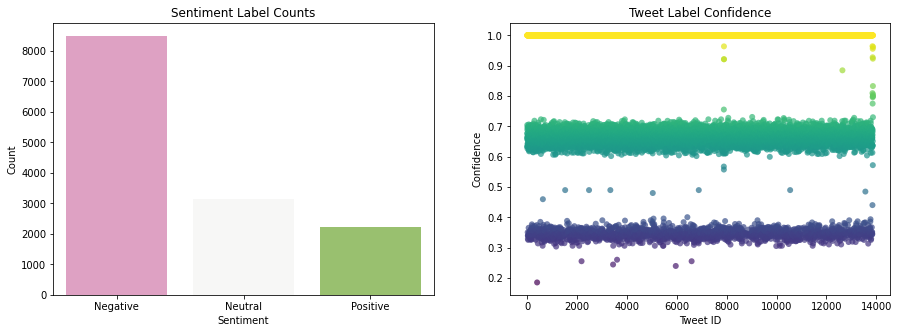

In [3]:
import seaborn as sns                  # importamos seaborn para visualización
import matplotlib.pyplot as plt

# gráfico de barras para mostrar el número de tweets etiquetados como Positivo / Neutral / Negativo
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(x="sentiment", order=["Negative","Neutral","Positive"], data=tweets_data_df, palette="PiYG", ax=ax1)
ax1.set_title("Sentiment Label Counts")
ax1.set_xlabel("Sentiment")
ax1.set_ylabel("Count")

# diagrama de dispersión que muestra la confianza de las etiquetas por tweet.
# útil para descartar tweets poco fiables. 
sns.scatterplot(x="id", y="sentiment_confidence", hue="sentiment_confidence", palette="viridis",
                sizes=(5,), linewidth=0, alpha=0.7,legend=False, data=tweets_data_df, ax=ax2)
ax2.set_title("Tweet Label Confidence")
ax2.set_xlabel("Tweet ID")
ax2.set_ylabel("Confidence")

## Filtrado de datos
Con base en las cifras anteriores, decidimos filtrar los datos que usaremos para construir nuestro clasificador y mantener solo las columnas de texto y sentimiento. Además, eliminamos las filas con `sentiment_confidence` por debajo de 0.5. Dado que realizaremos una clasificación binaria, eliminamos los tweets `Neutrales` y reemplazamos las cadenas` Negativo` y `Positivo` con etiquetas enteras (1 ó 0). Finalmente, un gran desequilibrio en el número de datos etiquetados para una categoría determinada puede afectar gravemente el desempeño de un clasificador. Por lo tanto, eliminamos aleatoriamente los tweets negativos para que coincidan con el número de muestras positivas en o conjunto de datos.

In [4]:
import numpy as np

# manteniendo solo filas con sentiment_confidence> 0.5
tweets_data_df = tweets_data_df[tweets_data_df["sentiment_confidence"]>0.5] 

# eliminar tweets negativos aleatorios
total_negative = tweets_data_df["sentiment"].value_counts()["Negative"] # count positive and negative rows
total_positive = tweets_data_df["sentiment"].value_counts()["Positive"]
to_remove = np.random.choice(tweets_data_df[tweets_data_df['sentiment']=="Negative"].index, # select random rows
                             size=total_negative-total_positive,
                             replace=False)
tweets_data_df = tweets_data_df.drop(to_remove) # remove

# manteniendo solo las columnas necesarias [['text','sentiment']]
tweets_data_df = tweets_data_df[["text","sentiment"]]         
# reemplace las etiquetas de las cadenas de sentimientos con números enteros y elimine los tweets neutrales. 
tweets_data_df = tweets_data_df[tweets_data_df["sentiment"]!="Neutral"]      
tweets_data_df["sentiment"][tweets_data_df["sentiment"]=="Negative"]  = 0   
tweets_data_df["sentiment"][tweets_data_df["sentiment"]=="Positive"]  = 1      
tweets_data_df

,text,sentiment
1,RT @ScottWalker: Didn't catch the full #GOPdeb...,1
3,RT @RobGeorge: That Carly Fiorina is trending ...,1
...,...,...
13868,"RT @Lrihendry: #TedCruz As President, I will a...",1
13870,RT @Lrihendry: #TedCruz headed into the Presid...,1


Comprobemos la distribución de salida usando un gráfico de barras

Text(0, 0.5, 'Count')

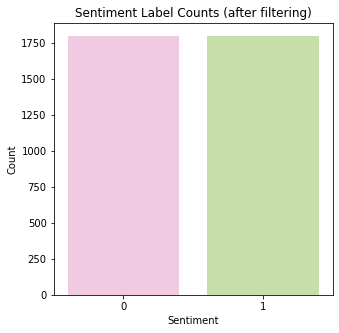

In [5]:
# gráfico de barras para mostrar el número de tweets etiquetados como Positivo / Neutral / Negativo
f, (ax1) = plt.subplots(1, 1, figsize=(5, 5))
sns.countplot(x="sentiment", order=[0,1], data=tweets_data_df, palette="PiYG", ax=ax1)
ax1.set_title("Sentiment Label Counts (after filtering)")
ax1.set_xlabel("Sentiment")
ax1.set_ylabel("Count")

Preparemos ahora el texto del tweet para que nuestro clasificador lo pueda interpretar. Usando herramientas de [NLTK](https://www.nltk.org/) primero eliminamos *palabras vacías* que son palabras que no tienen ningún significado importante para ser utilizadas en nuestro clasificador. Por lo general, estas palabras también se filtran de las consultas de búsqueda porque devuelven una gran cantidad de información innecesaria (por ejemplo, the, is, at, which, on, for, this, etc.). También eliminamos nombres de usuario, hashtags y URL. NLTK también nos proporciona un módulo de tweet *tokenizador* que divide las cadenas de tweets en una lista de palabras. Además, empleamos un *stemmer (lematizador)* para eliminar los afijos morfológicos de las palabras, dejando solo la raíz de la palabra (i.e.: "running" -> "run", "generously" -> "generous"). Finalmente, también eliminamos emojis comunes, hashtags, puntuación y números.

In [6]:
from nltk.corpus   import stopwords 
from nltk.tokenize import TweetTokenizer
from nltk.stem     import PorterStemmer
import nltk
import string
import re

# Conjunto de emojis para eliminar de los tweets
emojis = set([ ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
               ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
               '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
               'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)','<3',
               ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
               ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
               ':c', ':{', '>:\\', ';(', '🇺🇸'])
 
# Conjunto de palabras en inglés a descartar(stopwords)
nltk.download('stopwords')
stopwords_english  = set(stopwords.words("english"))
    
# Tokenizer 
tokenizer    = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)

def clean_tweet(tweet):
    
    # expresión regular: eliminar "RT" de los tweets
    tweet = re.sub(r'^RT[\s]+', '', tweet)
 
    # expresión regular: eliminar "URL" de los tweets
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    
    # expresión regular: eliminar "#" de los tweets
    tweet = re.sub(r'#', '', tweet)
    
    # expresión regular: eliminar "@" de los tweets
    tweet = re.sub(r'@', '', tweet)
 
    # tokenize
    tweet_tokens = tokenizer.tokenize(tweet)
    
    # PorterStemmer
    stemmer = PorterStemmer()
 
    tweet_clean = [] #lista vacia   
    for word in tweet_tokens:
        if (word not in stopwords_english and     # no stopwords
            word not in emojis and                # no emojis
            word not in string.punctuation):      # no puntuación
                stem_word = stemmer.stem(word)    # stemming word (lematizador)
                tweet_clean.append(stem_word)     # adjuntar las palabras importantes
 
    return tweet_clean

# obtener palabras limpias filtradas para cada tweet
tweets_data_df["text"] = tweets_data_df["text"].apply(lambda x: clean_tweet(x))
# eliminar palabras vacías y puntuación
tweets_data_df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,text,sentiment
1,"[scottwalk, catch, full, gopdeb, last, night, ...",1
3,"[robgeorg, carli, fiorina, trend, hour, debat,...",1
...,...,...
13868,"[lrihendri, tedcruz, presid, alway, tell, trut...",1
13870,"[lrihendri, tedcruz, head, presidenti, debat, ...",1


## Construyendo un clasificador de opiniones
Primero, identificamos y creamos un diccionario de palabras únicas usando el método [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) de scikit-learn . Para entrenar a un clasificador, necesitamos crear un vector que identifique cada tweet, esto se llama vector de características. El vectorizador nos ayuda a traducir cada palabra en un código entero único, extrayendo el *vocabulario* en nuestro conjunto de datos.

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

phrases    = [' '.join(x) for x in tweets_data_df["text"].values ] # Todas las frases de nuestros tweets
vectorizer = CountVectorizer() 
vectorizer = vectorizer.fit(phrases)
print("Vocabulary size:{}".format(len(vectorizer.vocabulary_)))
print("Vocabulary content:{}".format(vectorizer.vocabulary_))

Vocabulary size:5414
Vocabulary content:{'scottwalk': 4240, 'catch': 928, 'full': 2002, 'gopdeb': 2107, 'last': 2808, 'night': 3374, 'scott': 4234, 'best': 642, 'line': 2910, '90': 190, 'second': 4259, 'walker': 5204, '16': 33, 'robgeorg': 4096, 'carli': 905, 'fiorina': 1881, 'trend': 4966, 'hour': 2345, 'debat': 1364, 'men': 3116, 'just': 2670, 'complet': 1158, 'say': 4210, 'danscavino': 1330, 'realdonaldtrump': 3938, 'deliv': 1402, 'highest': 2286, 'rate': 3913, 'histori': 2305, 'presidenti': 3767, 'trump': 4982, '2016': 63, 'gregabbott_tx': 2167, 'tedcruz': 4773, 'first': 1884, 'day': 1345, 'rescind': 4021, 'everi': 1734, 'illeg': 2411, 'execut': 1762, 'action': 254, 'taken': 4733, 'barack': 566, 'obama': 3439, 'foxnew': 1955, 'jgreendc': 2596, 'fair': 1801, 'billclinton': 672, 'own': 3546, 'phrase': 3646, 'waynedupreeshow': 5238, 'woke': 5325, 'tweet': 5011, 'via': 5147, 'govmikehuckabe': 2141, 'pattonoswalt': 3596, 'love': 2975, 'mark': 3044, 'harmon': 2238, 'romant': 4105, 'rival

Usando el método scikit-learn [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html), ahora dividimos el conjunto de datos en un conjunto de entrenamiento y de prueba. Definimos un conjunto de prueba alrededor del 10% del tamaño del conjunto de datos original.

In [8]:
# función para dividir datos para entrenar y probar conjuntos
from sklearn.model_selection import train_test_split            

# Dividir el conjunto de datos en conjunto de entrenamiento y de prueba
train, test = train_test_split(tweets_data_df,test_size = 0.1)

In [9]:
train

,text,sentiment
12297,"[rwsurfergirl, jeb, bush, remind, elev, music,...",0
12673,"[trump, countri, own, 19, trillion, dollar, ne...",1
...,...,...
3645,"[gop, w, gopdeb, prove, thestupidparti, ..., h...",0
4656,"[realdonaldtrump, took, advantag, chapter, law...",0


In [10]:
test

,text,sentiment
5558,"[gopdeb, omg, dream, ticket, would, randpaul, ...",1
3098,"[we'r, go, talk, trump', bankruptci, fiorina',...",0
...,...,...
3682,"[frankluntz, lol, probabl, like, loser, candid...",1
13528,"[johnschamb, trump, 2016, gopdeb, final, someo...",1


Ahora, necesitamos transformar tokens en cada partición en vectores de características. Usaremos nuestro vectorizador para transformar cada tweet en una [*bolsa de palabras*](https://en.wikipedia.org/wiki/Bag-of-words_model).

In [11]:
X_train              = [' '.join(x) for x in train['text'].values ] 
X_train_bag_of_words = vectorizer.transform(X_train)
y_train              = train['sentiment'].values.astype(int)

X_test              = [ ' '.join(x) for x in test['text'].values ] 
X_test_bag_of_words = vectorizer.transform(X_test)
y_test              = test['sentiment'].values.astype(int)

Al imprimir instancias del conjunto de datos de entrenamiento después de la transformación * bolsa de palabras *, vemos pares como `(0, 628) 1`. El primer número identifica el índice de la frase (el tweet), el segundo número es el código de palabra asignado por nuestro vectorizador, finalmente, el último número es el recuento de apariciones de la palabra.

In [12]:
# Impresión de la bolsa de palabras 0
print(X_train_bag_of_words[0])

  (0, 840)	1
  (0, 1637)	1
  (0, 2107)	2
  (0, 2257)	1
  (0, 2566)	1
  (0, 2920)	1
  (0, 3275)	1
  (0, 3993)	1
  (0, 4153)	1


Finalmente, ajustamos el modelo [Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

In [13]:
from sklearn.ensemble import RandomForestClassifier
gnb = RandomForestClassifier(class_weight="balanced")
gnb.fit(X_train_bag_of_words.toarray(), y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Calculemos métricas de clasificación estándar.

In [14]:
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, accuracy_score, classification_report

y_pred_test  = gnb.predict(X_test_bag_of_words.toarray())

print(" <================= Testing dataset metrics =================> ")
print("Number of mislabeled test points out of a total {} points : {}".format(X_test_bag_of_words.toarray().shape[0],(y_test != y_pred_test).sum()))
print("Confusion matrix:\n",confusion_matrix(y_test, y_pred_test),"\n")
print("Balanced accuracy score:",balanced_accuracy_score(y_test, y_pred_test))
print("Full Report:\n",classification_report(y_test, y_pred_test))

 <================= Testing dataset metrics =================> 
Number of mislabeled test points out of a total 361 points : 70
Confusion matrix:
 [[145  38]
 [ 32 146]] 

Balanced accuracy score: 0.8062872229385399
Full Report:
               precision    recall  f1-score   support

           0       0.82      0.79      0.81       183
           1       0.79      0.82      0.81       178

    accuracy                           0.81       361
   macro avg       0.81      0.81      0.81       361
weighted avg       0.81      0.81      0.81       361

